## Settings

In [1]:
# CONTROLS
MODEL_PREFIX = "V02"
MODEL_NUMBER = MODEL_PREFIX[-2:]
TRAIN_SPLIT_RATIO = 0.8

DROPOUT = 0.1
MIN_LR = 1e-5
MAX_LR = 1e-3
BATCH_SIZE = 128
PREDICT_BATCH_SIZE = 2048
STEP_SIZE = 20
CLR_METHOD = "triangular2" # exp_range, triangular, triangular2
NUM_EPOCHS = 200

## Libraries

In [2]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

from sklearn.preprocessing import MinMaxScaler, LabelBinarizer
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score
from sklearn.utils import class_weight

import pickle, os, sys

import tensorflow as tf
from tensorflow.keras import Model, Input
from tensorflow.keras.layers import Conv1D, Conv2D, LSTM, Embedding, Dense, concatenate, MaxPooling2D
from tensorflow.keras.layers import BatchNormalization, Dropout, Flatten, Reshape, Activation, Bidirectional
from tensorflow.keras.optimizers import Adam

def signaltonoise(a, axis=0, ddof=0):
    a = np.asanyarray(a)
    m = a.mean(axis)
    sd = a.std(axis=axis, ddof=ddof)
    return np.where(sd == 0, 0, m/sd)

%matplotlib inline

In [3]:
#import os
#os.environ["TF_FORCE_GPU_ALLOW_GROWTH"]="true"

In [4]:
from tensorflow.keras.callbacks import *
import tensorflow.keras.backend as K

class CyclicLR(Callback):
    """This callback implements a cyclical learning rate policy (CLR).
    The method cycles the learning rate between two boundaries with
    some constant frequency, as detailed in this paper (https://arxiv.org/abs/1506.01186).
    The amplitude of the cycle can be scaled on a per-iteration or 
    per-cycle basis.
    This class has three built-in policies, as put forth in the paper.
    "triangular":
        A basic triangular cycle w/ no amplitude scaling.
    "triangular2":
        A basic triangular cycle that scales initial amplitude by half each cycle.
    "exp_range":
        A cycle that scales initial amplitude by gamma**(cycle iterations) at each 
        cycle iteration.
    For more detail, please see paper.
    
    # Example
        ```python
            clr = CyclicLR(base_lr=0.001, max_lr=0.006,
                                step_size=2000., mode='triangular')
            model.fit(X_train, Y_train, callbacks=[clr])
        ```
    
    Class also supports custom scaling functions:
        ```python
            clr_fn = lambda x: 0.5*(1+np.sin(x*np.pi/2.))
            clr = CyclicLR(base_lr=0.001, max_lr=0.006,
                                step_size=2000., scale_fn=clr_fn,
                                scale_mode='cycle')
            model.fit(X_train, Y_train, callbacks=[clr])
        ```    
    # Arguments
        base_lr: initial learning rate which is the
            lower boundary in the cycle.
        max_lr: upper boundary in the cycle. Functionally,
            it defines the cycle amplitude (max_lr - base_lr).
            The lr at any cycle is the sum of base_lr
            and some scaling of the amplitude; therefore 
            max_lr may not actually be reached depending on
            scaling function.
        step_size: number of training iterations per
            half cycle. Authors suggest setting step_size
            2-8 x training iterations in epoch.
        mode: one of {triangular, triangular2, exp_range}.
            Default 'triangular'.
            Values correspond to policies detailed above.
            If scale_fn is not None, this argument is ignored.
        gamma: constant in 'exp_range' scaling function:
            gamma**(cycle iterations)
        scale_fn: Custom scaling policy defined by a single
            argument lambda function, where 
            0 <= scale_fn(x) <= 1 for all x >= 0.
            mode paramater is ignored 
        scale_mode: {'cycle', 'iterations'}.
            Defines whether scale_fn is evaluated on 
            cycle number or cycle iterations (training
            iterations since start of cycle). Default is 'cycle'.
    """

    def __init__(self, base_lr=0.001, max_lr=0.006, step_size=2000., mode='triangular',
                 gamma=1., scale_fn=None, scale_mode='cycle'):
        super(CyclicLR, self).__init__()

        self.base_lr = base_lr
        self.max_lr = max_lr
        self.step_size = step_size
        self.mode = mode
        self.gamma = gamma
        if scale_fn == None:
            if self.mode == 'triangular':
                self.scale_fn = lambda x: 1.
                self.scale_mode = 'cycle'
            elif self.mode == 'triangular2':
                self.scale_fn = lambda x: 1/(2.**(x-1))
                self.scale_mode = 'cycle'
            elif self.mode == 'exp_range':
                self.scale_fn = lambda x: gamma**(x)
                self.scale_mode = 'iterations'
        else:
            self.scale_fn = scale_fn
            self.scale_mode = scale_mode
        self.clr_iterations = 0.
        self.trn_iterations = 0.
        self.history = {}

        self._reset()

    def _reset(self, new_base_lr=None, new_max_lr=None,
               new_step_size=None):
        """Resets cycle iterations.
        Optional boundary/step size adjustment.
        """
        if new_base_lr != None:
            self.base_lr = new_base_lr
        if new_max_lr != None:
            self.max_lr = new_max_lr
        if new_step_size != None:
            self.step_size = new_step_size
        self.clr_iterations = 0.
        
    def clr(self):
        cycle = np.floor(1+self.clr_iterations/(2*self.step_size))
        x = np.abs(self.clr_iterations/self.step_size - 2*cycle + 1)
        if self.scale_mode == 'cycle':
            return self.base_lr + (self.max_lr-self.base_lr)*np.maximum(0, (1-x))*self.scale_fn(cycle)
        else:
            return self.base_lr + (self.max_lr-self.base_lr)*np.maximum(0, (1-x))*self.scale_fn(self.clr_iterations)
        
    def on_train_begin(self, logs={}):
        logs = logs or {}

        if self.clr_iterations == 0:
            K.set_value(self.model.optimizer.lr, self.base_lr)
        else:
            K.set_value(self.model.optimizer.lr, self.clr())        
            
    def on_batch_end(self, epoch, logs=None):
        
        logs = logs or {}
        self.trn_iterations += 1
        self.clr_iterations += 1

        self.history.setdefault('lr', []).append(K.get_value(self.model.optimizer.lr))
        self.history.setdefault('iterations', []).append(self.trn_iterations)

        for k, v in logs.items():
            self.history.setdefault(k, []).append(v)
        
        K.set_value(self.model.optimizer.lr, self.clr())

## Import Data

In [5]:
df = pd.read_csv("../data/train.csv", dtype={"time":np.float64,"signal":np.float64,"open_channels":np.int16})
print(pd.concat((df.dtypes, df.isna().sum()), axis=1))
print(df.shape)

# Counts of various columns
print({i:df[i].nunique() for i in df.columns})
print(df.describe()) #.astype(int)
df.head(5)

                    0  1
textID         object  0
text           object  1
selected_text  object  1
sentiment      object  0
(27481, 4)
{'textID': 27481, 'text': 27480, 'selected_text': 22463, 'sentiment': 3}
            textID                                               text  \
count        27481                                              27480   
unique       27481                                              27480   
top     f9d3b11eae   - Hey, Lenny, we are waiting you in Bulgaria ...   
freq             1                                                  1   

       selected_text sentiment  
count          27480     27481  
unique         22463         3  
top             good   neutral  
freq             199     11118  


,textID,text,selected_text,sentiment
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",neutral
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative
2,088c60f138,my boss is bullying me...,bullying me,negative
3,9642c003ef,what interview! leave me alone,leave me alone,negative
4,358bd9e861,"Sons of ****, why couldn`t they put them on t...","Sons of ****,",negative


In [6]:
test_df = pd.read_csv("../data/test.csv", dtype={"time":np.float64,"signal":np.float64})
print(pd.concat((test_df.dtypes, test_df.isna().sum()), axis=1))
print(test_df.shape)

# Counts of various columns
print({i:test_df[i].nunique() for i in test_df.columns})
print(test_df.describe())
test_df.head(5)

                0  1
textID     object  0
text       object  0
sentiment  object  0
(3534, 3)
{'textID': 3534, 'text': 3534, 'sentiment': 3}
            textID                                               text  \
count         3534                                               3534   
unique        3534                                               3534   
top     69d6b5d93e  Going to clean my room but thats not hard. i k...   
freq             1                                                  1   

       sentiment  
count       3534  
unique         3  
top      neutral  
freq        1430  


,textID,text,sentiment
0,f87dea47db,Last session of the day http://twitpic.com/67ezh,neutral
1,96d74cb729,Shanghai is also really exciting (precisely -...,positive
2,eee518ae67,"Recession hit Veronique Branquinho, she has to...",negative
3,01082688c6,happy bday!,positive
4,33987a8ee5,http://twitpic.com/4w75p - I like it!!,positive


In [7]:
df["original_index"] = df.index
test_df["original_index"] = test_df.index

## Exploration

#### Sentiment count in training

In [8]:
pd.concat([df.groupby("sentiment")[["text"]].count(), test_df.groupby("sentiment")[["text"]].count()], axis=1)

,text,text
sentiment,,
negative,7781,1001
neutral,11117,1430
positive,8582,1103


In [9]:
import spacy
import en_core_web_sm
nlp = en_core_web_sm.load()

## Preprocessing

In [10]:
from tensorflow.keras.preprocessing.text import Tokenizer

In [11]:
df["sentiment_code"] = df["sentiment"].astype("category")
X_sentiments = df["sentiment_code"].cat.codes.values

test_df["sentiment_code"] = test_df["sentiment"].astype("category")
X_sentiments_test = test_df["sentiment_code"].cat.codes.values

#### Tokenization

In [12]:
df["text"] = df["text"].astype(str)
df["selected_text"] = df["selected_text"].astype(str)
test_df["text"] = test_df["text"].astype(str)

In [13]:
texts = df["text"].tolist()

In [14]:
max_len = max([len(i.split(" ")) for i in texts])

In [15]:
Tkn = Tokenizer() # num_words=
Tkn.fit_on_texts(texts)
X = Tkn.texts_to_sequences(texts)

In [16]:
selected_texts = df["selected_text"].tolist()
Y = Tkn.texts_to_sequences(selected_texts)
Y2 = [[1 if j in y else 0 for j in X[i]] for i,y in enumerate(Y)]

In [17]:
test_texts = test_df["text"].tolist()
X_test = Tkn.texts_to_sequences(test_texts)

In [18]:
max_len_y = max([len(i) for i in Y2])

In [19]:
print(max_len, max_len_y)

101 35


#### Test Train split

In [20]:
np.random.seed(100)
idx = [i for i in np.arange(len(Y))]
np.random.shuffle(idx)
train_idx, val_idx = idx[:round(TRAIN_SPLIT_RATIO*len(Y))], idx[round(TRAIN_SPLIT_RATIO*len(Y)):]

print(len(idx), len(train_idx), len(val_idx), len(train_idx) + len(val_idx))

27481 21985 5496 27481


In [21]:
X_train, X_val = [X[i] for i in train_idx], [X[i] for i in val_idx]
X_sentiments_train, X_sentiments_val = [X_sentiments[i] for i in train_idx], [X_sentiments[i] for i in val_idx]
X_sentiments_train, X_sentiments_val = np.array(X_sentiments_train, dtype=np.int32), np.array(X_sentiments_val, dtype=np.int32)
Y_train, Y_val = [Y[i] for i in train_idx], [Y[i] for i in val_idx]
Y2_train, Y2_val = [Y2[i] for i in train_idx], [Y2[i] for i in val_idx]

[len(i) for i in [X_train, X_val, X_sentiments_train, X_sentiments_val, Y_train, Y_val, Y2_train, Y2_val]]

[21985, 5496, 21985, 5496, 21985, 5496, 21985, 5496]

#### Padding

In [22]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [23]:
X_train = pad_sequences(X_train, maxlen=max_len + 1, padding="post")
Y_train = pad_sequences(Y_train, maxlen=max_len + 1, padding="post")
Y2_train = pad_sequences(Y2_train, maxlen=max_len + 1, padding="post")

X_val = pad_sequences(X_val, maxlen=max_len + 1, padding="post")
Y_val = pad_sequences(Y_val, maxlen=max_len + 1, padding="post")
Y2_val = pad_sequences(Y2_val, maxlen=max_len + 1, padding="post")

X_test = pad_sequences(X_test, maxlen=max_len + 1, padding="post")

In [24]:
print(X_train.shape, X_sentiments_train.shape, X_val.shape, X_sentiments_val.shape, X_test.shape)
print(Y_train.shape, Y2_train.shape, Y_val.shape, Y2_val.shape)

(21985, 102) (21985,) (5496, 102) (5496,) (3534, 102)
(21985, 102) (21985, 102) (5496, 102) (5496, 102)


In [25]:
VOCAB_SIZE = max(Tkn.index_word.keys())

#### Checking for zero input vectors

In [26]:
keep_x_train = X_train.sum(axis=1) > 0
X_train, Y_train = X_train[keep_x_train], Y_train[keep_x_train]
X_sentiments_train, Y2_train = X_sentiments_train[keep_x_train], Y2_train[keep_x_train]

keep_x_val = X_val.sum(axis=1) > 0
X_val, Y_val = X_val[keep_x_val], Y_val[keep_x_val]
X_sentiments_val, Y2_val = X_sentiments_val[keep_x_val], Y2_val[keep_x_val]

keep_x_test = X_test.sum(axis=1) > 0
test_df["kept"] = keep_x_test
X_test, X_sentiments_test = X_test[keep_x_test], X_sentiments_test[keep_x_test]

In [27]:
print(np.argmax([X_train.sum(axis=1)==0]), np.min([X_train.sum(axis=1)]))
print(np.argmax([X_val.sum(axis=1)==0]), np.min([X_val.sum(axis=1)]))

0 6
0 37


## Model

In [37]:
from tensorflow.keras.layers import TimeDistributed

In [40]:
input_sentiment = Input((1))
input_sequences = Input((max_len+1))

emb_sequences = Embedding(input_dim=VOCAB_SIZE+1, input_length=max_len+1, output_dim=32, mask_zero=True)(input_sequences)

seq = Bidirectional(LSTM(32, return_sequences=True))(emb_sequences)
seq = BatchNormalization()(seq)
seq = Dropout(DROPOUT)(seq)

seq = Bidirectional(LSTM(32, return_sequences=True))(seq)
seq = BatchNormalization()(seq)
seq = Dropout(DROPOUT)(seq)

seq = TimeDistributed(Dense(64, activation="relu"))(seq)
seq = BatchNormalization()(seq)
seq = Dropout(DROPOUT)(seq)

seq = Flatten()(seq)

emb_sentiment = Embedding(input_dim=3, input_length=1, output_dim=5)(input_sentiment)
senti = Dense(8, activation="relu")(emb_sentiment)
senti = BatchNormalization()(senti)
senti = Dropout(DROPOUT)(senti)
senti = Flatten()(senti)

concat_layer = concatenate([senti, seq])
output = Dense(max_len+1, activation="sigmoid")(concat_layer)

In [41]:
model = Model([input_sentiment, input_sequences], output)
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            [(None, 102)]        0                                            
__________________________________________________________________________________________________
embedding_4 (Embedding)         (None, 102, 32)      851168      input_6[0][0]                    
__________________________________________________________________________________________________
bidirectional_4 (Bidirectional) (None, 102, 64)      16640       embedding_4[0][0]                
__________________________________________________________________________________________________
batch_normalization_8 (BatchNor (None, 102, 64)      256         bidirectional_4[0][0]            
____________________________________________________________________________________________

In [42]:
adam = Adam(learning_rate=MIN_LR)

model.compile(loss='binary_crossentropy',
              optimizer=adam, metrics=['accuracy'])

#model.compile(loss='sparse_categorical_crossentropy',
#              optimizer=adam) #, metrics=['accuracy']

In [43]:
#callbacks
mcp = ModelCheckpoint(filepath="../results/"+MODEL_PREFIX+"Checkpoint.h5",
                      monitor='val_loss',
                      mode="auto",
                      save_weights_only=False,
                      save_best_only=True)

clr = CyclicLR(mode=CLR_METHOD,
               base_lr=MIN_LR,
               max_lr=MAX_LR,
               step_size= STEP_SIZE * (X_train.shape[0] // BATCH_SIZE))

In [44]:
history = model.fit(x=[X_sentiments_train, X_train],
                    y=Y2_train,
                    shuffle=True,
                    batch_size=BATCH_SIZE,
                    epochs=NUM_EPOCHS,
                    validation_data=([X_sentiments_val, X_val], Y2_val),
                    verbose=1,
                    callbacks=[clr, mcp]) #es, rlrop, tb, mcp, 

#history = model.fit(x=[X_sentiments_train, X_train],
#                    y=Y_train,
#                    shuffle=True,
#                    batch_size=BATCH_SIZE,
#                    epochs=NUM_EPOCHS,
#                    validation_data=([X_sentiments_val, X_val], Y_val),
#                    verbose=1,
#                    callbacks=[clr, mcp]) #es, rlrop, tb, mcp, 

Train on 21984 samples, validate on 5495 samples
Epoch 1/200
21984/21984 [==============================] - 22s 1ms/sample - loss: 0.3406 - accuracy: 0.8510 - val_loss: 0.2444 - val_accuracy: 0.9329
Epoch 2/200
21984/21984 [==============================] - 7s 320us/sample - loss: 0.1210 - accuracy: 0.9372 - val_loss: 0.1916 - val_accuracy: 0.9318
Epoch 3/200
21984/21984 [==============================] - 7s 314us/sample - loss: 0.1004 - accuracy: 0.9442 - val_loss: 0.1561 - val_accuracy: 0.9340
Epoch 4/200
21984/21984 [==============================] - 7s 313us/sample - loss: 0.0863 - accuracy: 0.9541 - val_loss: 0.0893 - val_accuracy: 0.9502
Epoch 5/200
21984/21984 [==============================] - 7s 312us/sample - loss: 0.0727 - accuracy: 0.9644 - val_loss: 0.0719 - val_accuracy: 0.9685
Epoch 6/200
21984/21984 [==============================] - 7s 340us/sample - loss: 0.0611 - accuracy: 0.9719 - val_loss: 0.0659 - val_accuracy: 0.9702
Epoch 7/200
21984/21984 [=====================

21984/21984 [==============================] - 7s 315us/sample - loss: 7.9495e-04 - accuracy: 0.9997 - val_loss: 0.3636 - val_accuracy: 0.9573
Epoch 108/200
21984/21984 [==============================] - 7s 316us/sample - loss: 7.4390e-04 - accuracy: 0.9997 - val_loss: 0.3631 - val_accuracy: 0.9576
Epoch 109/200
21984/21984 [==============================] - 7s 316us/sample - loss: 7.3391e-04 - accuracy: 0.9997 - val_loss: 0.3580 - val_accuracy: 0.9577
Epoch 110/200
21984/21984 [==============================] - 7s 315us/sample - loss: 7.0347e-04 - accuracy: 0.9998 - val_loss: 0.3616 - val_accuracy: 0.9574
Epoch 111/200
21984/21984 [==============================] - 7s 315us/sample - loss: 6.6851e-04 - accuracy: 0.9998 - val_loss: 0.3654 - val_accuracy: 0.9573
Epoch 112/200
21984/21984 [==============================] - 7s 316us/sample - loss: 6.3074e-04 - accuracy: 0.9998 - val_loss: 0.3741 - val_accuracy: 0.9571
Epoch 113/200
21984/21984 [==============================] - 7s 315us/sa

## Validation

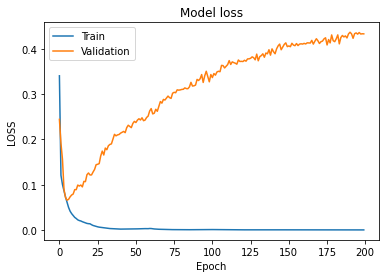

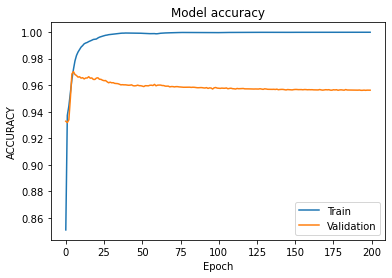

In [45]:
metric_names = ['loss' ,'accuracy']

for i, j in zip(metric_names, ['val_'+i for i in metric_names]):
    plt.plot(history.history[i])
    plt.plot(history.history[j])
    plt.title('Model '+i)
    plt.ylabel(i.upper())
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'])
    plt.show()

#### Inference

In [47]:
from tensorflow.keras.models import load_model

model = tf.keras.models.load_model(
    filepath="../results/"+MODEL_PREFIX+"Checkpoint.h5",
    compile=True
)

In [48]:
pred_train = model.predict(x = [X_sentiments_train, X_train], batch_size=PREDICT_BATCH_SIZE)
pred_val = model.predict(x = [X_sentiments_val, X_val], batch_size=PREDICT_BATCH_SIZE)
pred_test = model.predict(x = [X_sentiments_test, X_test], batch_size=PREDICT_BATCH_SIZE)

In [49]:
X_train.shape, Y_train.shape, pred_train.shape

((21984, 102), (21984, 102), (21984, 102))

#### Postprocessing

In [50]:
pred_train_words = [i[j>0.5].tolist() for i,j in zip(X_train, pred_train)]
pred_val_words = [i[j>0.5].tolist() for i,j in zip(X_val, pred_val)]
pred_test_words = [i[j>0.5].tolist() for i,j in zip(X_test, pred_test)]

In [51]:
pred_train_words = Tkn.sequences_to_texts(pred_train_words)
pred_val_words = Tkn.sequences_to_texts(pred_val_words)
pred_test_words = Tkn.sequences_to_texts(pred_test_words)

In [52]:
from sklearn.metrics import jaccard_score

In [53]:
def jaccard(str1, str2):
    a = set(str1.lower().split()) 
    b = set(str2.lower().split())
    c = a.intersection(b)
    return float(len(c)) / (len(a) + len(b) - len(c))

In [54]:
len(train_idx), keep_x_train.shape, pred_train.shape

(21985, (21985,), (21984, 102))

In [55]:
predictions = pd.DataFrame({
    "pred_selected_text" : pred_train_words + pred_val_words,
    "original_index" : np.concatenate((np.array(train_idx, dtype=np.int64)[keep_x_train],
                                       np.array(val_idx, dtype=np.int64)[keep_x_val])),
    "set" : ["train" for i in range(sum(keep_x_train))] + ["val" for i in range(sum(keep_x_val))]
})

In [56]:
assert (predictions.original_index.min(), predictions.original_index.max()) == (df.original_index.min(), df.original_index.max())

In [57]:
print(df.shape, predictions.shape)
results = pd.merge(df, predictions, on = "original_index", how="inner")
print(df.shape, predictions.shape, results.shape)

(27481, 6) (27479, 3)
(27481, 6) (27479, 3) (27479, 8)


In [58]:
results.loc[results.set=="val"].head(10)

,textID,text,selected_text,sentiment,original_index,sentiment_code,pred_selected_text,set
9,fc2cbefa9d,Journey!? Wow... u just became cooler. hehe....,Wow... u just became cooler.,positive,9,positive,wow,val
17,919fa93391,i`ve been sick for the past few days and thus...,sick,negative,17,negative,i ve,val
27,bdc32ea43c,On the way to Malaysia...no internet access to...,.no internet,negative,27,negative,the no access to,val
28,6ce4a4954b,juss came backk from Berkeleyy ; omg its madd ...,fun,positive,28,positive,,val
39,2863f435bd,A little happy for the wine jeje ok it`sm my f...,A little happy fo,positive,39,positive,i love this day,val
40,d93afa85cf,"Car not happy, big big dent in boot! Hoping t...","Car not happy, big big dent in boot! Hoping th...",neutral,40,neutral,car not happy big big dent in boot hoping they...,val
44,c77717b103,I love to! But I`m only available from 5pm. ...,I love to!,positive,44,positive,help her,val
45,a9d499e123,The girl in the hair salon asked me 'Shall I t...,The girl in the hair salon asked me 'Shall I t...,neutral,45,neutral,the girl in the hair salon asked me 'shall i t...,val
60,52483f7da8,"i lost all my friends, i`m alone and sleepy..i...","i lost all my friends, i`m alone and sleepy..",negative,60,negative,,val
63,90a2cdb657,What better way to spoil mum than to let her k...,favorite,positive,63,positive,than let her kick bottle of a,val


In [59]:
results.loc[results.set=="train"].head(10)

,textID,text,selected_text,sentiment,original_index,sentiment_code,pred_selected_text,set
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",neutral,0,neutral,i d have responded if i were going,train
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative,1,negative,sad,train
2,088c60f138,my boss is bullying me...,bullying me,negative,2,negative,is bullying,train
3,9642c003ef,what interview! leave me alone,leave me alone,negative,3,negative,what interview leave me,train
4,358bd9e861,"Sons of ****, why couldn`t they put them on t...","Sons of ****,",negative,4,negative,,train
5,28b57f3990,http://www.dothebouncy.com/smf - some shameles...,http://www.dothebouncy.com/smf - some shameles...,neutral,5,neutral,http www dothebouncy com smf some shameless pl...,train
6,6e0c6d75b1,2am feedings for the baby are fun when he is a...,fun,positive,6,positive,,train
7,50e14c0bb8,Soooo high,Soooo high,neutral,7,neutral,soooo high,train
8,e050245fbd,Both of you,Both of you,neutral,8,neutral,both of you,train
10,2339a9b08b,"as much as i love to be hopeful, i reckon the...","as much as i love to be hopeful, i reckon the ...",neutral,10,neutral,as much as i love to be hopeful i reckon the c...,train


In [ ]:
conf_mat_train = confusion_matrix(Y_train.argmax(axis=1).reshape(-1), pred_train.reshape(-1))
conf_mat_val = confusion_matrix(Y_val.argmax(axis=1).reshape(-1), pred_val.reshape(-1))
print("The train accuracy is\t",np.round(100 * np.sum(np.diag(conf_mat_train)) / np.sum(conf_mat_train),2))
print("The valid accuracy is\t",np.round(100 * np.sum(np.diag(conf_mat_val)) / np.sum(conf_mat_val),2))

np.savetxt(X=conf_mat_train, fname="../results/ConfMatrix_train_" + MODEL_PREFIX + ".txt")
np.savetxt(X=conf_mat_val, fname="../results/ConfMatrix_val_" + MODEL_PREFIX + ".txt")

f1_train = f1_score(Y_train.argmax(axis=1).reshape(-1), pred_train.reshape(-1), average='macro')
f1_val = f1_score(Y_val.argmax(axis=1).reshape(-1), pred_val.reshape(-1), average='macro')
print("The train macro f1score is\t",np.round(f1_train,2))
print("The valid macro f1score is\t",np.round(f1_val,2))

In [ ]:
submission = pd.DataFrame({'time':test_df['time'],'open_channels':pred_test.reshape(-1)})
submission.to_csv("../results/submission_20200412V"+MODEL_NUMBER+".csv", index=False, float_format='%.4f')

In [ ]:
from tensorflow.keras.models import load_model

best_model = tf.keras.models.load_model(
    filepath="../results/"+MODEL_PREFIX+"Checkpoint.h5",
    compile=True,
    custom_objects = {'macro_soft_f1':macro_soft_f1, 'macro_f1':macro_f1}
)

In [ ]:
pred_train = best_model.predict(x = X_train, batch_size=PREDICT_BATCH_SIZE)
pred_val = best_model.predict(x = X_val, batch_size=PREDICT_BATCH_SIZE)
pred_test = best_model.predict(x = X_test, batch_size=PREDICT_BATCH_SIZE)

In [ ]:
pred_train = pred_train.argmax(axis=1)
pred_val = pred_val.argmax(axis=1)
pred_test = pred_test.argmax(axis=1)

In [ ]:
conf_mat_train = confusion_matrix(Y_train.argmax(axis=1).reshape(-1), pred_train.reshape(-1))
conf_mat_val = confusion_matrix(Y_val.argmax(axis=1).reshape(-1), pred_val.reshape(-1))

print("The train accuracy is\t",np.round(100 * np.sum(np.diag(conf_mat_train)) / np.sum(conf_mat_train),2))
print("The valid accuracy is\t",np.round(100 * np.sum(np.diag(conf_mat_val)) / np.sum(conf_mat_val),2))

np.savetxt(X=conf_mat_train, fname="../results/BestConfMatrix_train_" + MODEL_PREFIX + ".txt")
np.savetxt(X=conf_mat_val, fname="../results/BestConfMatrix_val_" + MODEL_PREFIX + ".txt")

f1_train = f1_score(Y_train.argmax(axis=1).reshape(-1), pred_train.reshape(-1), average='macro')
f1_val = f1_score(Y_train.argmax(axis=1).reshape(-1), pred_train.reshape(-1), average='macro')
print("The train macro f1score is\t",np.round(f1_train,2))
print("The valid macro f1score is\t",np.round(f1_val,2))

In [ ]:
submission = pd.DataFrame({'time':test_df['time'],'open_channels':pred_test.reshape(-1)})
submission.to_csv("../results/best_submission_20200412V"+MODEL_NUMBER+".csv", index=False, float_format='%.4f')